In [1]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SW교육지원팀\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SW교육지원팀\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

x_train, x_test, t_train, t_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [3]:
from collections import OrderedDict

class Affine:

  def __init__(self, W):
    self.W = W
    self.x = None
    self.dW = None

  def forward(self, x):
    x = np.concatenate((np.expand_dims(np.ones(x.shape[0]), axis = 1), x), axis = 1)
    self.x = x
    out = np.dot(x, self.W)
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T[:,1:])
    self.dW = np.dot(self.x.T, dout)
    return dx

class sigmoid:

  def __init__(self):
    self.out = None

  def forward(self,x):
      out = 1. / (1. + np.exp(-x))
      self.out = out
      return out

  def backward(self,dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class ThreeLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, rambda, std = 0.1):
        
        self.rambda = rambda
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size+1, hidden_size1)  # xavier
        self.params['W2'] = std * np.random.randn(hidden_size1+1, hidden_size2) 
        self.params['W3'] = std * np.random.randn(hidden_size2+1, output_size) 
        #np.concatenate((np.random.randn(input_size+1, hidden_size1).T, np.expand_dims(np.ones(hidden_size1), axis = 1)), axis = 1)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'])
        self.layers['sigmoid1'] = sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'])
        self.layers['sigmoid2'] = sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'])
        self.layers['sigmoid3'] = sigmoid()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블

    def loss(self, x, t, rambda):
        a = self.predict(x).T
        t = np.expand_dims(t, axis = 1).T
        delta = 1e-7
        return -np.sum(t * np.log(a + delta) + (1-t) * np.log(1-a+delta)) / float(x.shape[0]) \
    + rambda / 2 / (len(network.params['W1'])+len(network.params['W2']+len(network.params['W3']))) \
    * (np.sum(np.power(self.params['W1'], 2))+np.sum(np.power(self.params['W2'],2))+np.sum(np.power(self.params['W3'],2)))


    def accuracy(self, x, t):
        y = self.predict(x)
        a = np.zeros_like(y, dtype = int)
        a[y >= 1/2] = 1
        t = np.expand_dims(t, axis = 1)
        accuracy = np.sum(a == t) / float(x.shape[0])
        return accuracy

        
    # x : 입력 데이터, t : 정답 레이블

    def gradient(self, x, t, rambda):
 
        y = self.predict(x)
        t = np.expand_dims(t, axis = 1)
        dout = y-t

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['W2'] = self.layers['Affine2'].dW
        grads['W3'] = self.layers['Affine3'].dW

        return grads

In [17]:
network = ThreeLayerNet(input_size=1500, hidden_size1=198, hidden_size2 = 49, output_size= 1, rambda = 10)
iters_num = 10000
train_size = x_train.shape[0]
learning_rate = 0.001
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
decay = 0.001

for i in range(iters_num):
    
    grad = network.gradient(x_train, t_train, network.rambda) 
    for key in ('W1','W2','W3'):
        network.params[key] -= learning_rate * grad[key] + learning_rate * network.rambda / x_train.shape[0] * network.params[key]
    
    train_loss = network.loss(x_train, t_train, network.rambda)  
    test_loss = network.loss(x_test, t_test, network.rambda)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc, train_loss, test_loss)
    if i % 10 == 0:
        learning_rate = learning_rate * 1/(1 + decay)
    if i > 100:
        if abs(train_loss_list[-1] - train_loss_list[-2])< 0.00008:
            break 

0.5017844396859387 0.49584026622296173 9.74757761645519 9.747884952960252
0.5324768022840828 0.4858569051580699 9.747431046009611 9.747685641354645
0.5260528194147038 0.5058236272878536 9.74730028150234 9.747568527682724
0.5189150606709493 0.49417637271214643 9.747170346952291 9.747435741066996
0.5210563882940756 0.49916805324459235 9.747040514245938 9.747307160869855
0.5210563882940756 0.49916805324459235 9.746910689352102 9.747177568372143
0.5217701641684511 0.49916805324459235 9.74678087865687 9.747048244490593
0.5217701641684511 0.49916805324459235 9.746651079510185 9.746918869559913
0.5217701641684511 0.49916805324459235 9.746521292501102 9.746789523033627
0.523197715917202 0.49916805324459235 9.746391517472889 9.74666018513753
0.523197715917202 0.49916805324459235 9.746261754458487 9.746530860789047
0.5239114917915775 0.49916805324459235 9.746132133063087 9.746401677942526
0.523197715917202 0.502495840266223 9.746002523641293 9.74627250769489
0.523197715917202 0.502495840266223 9

0.5531763026409707 0.5257903494176372 9.7330344951661 9.733351982040839
0.5531763026409707 0.5257903494176372 9.732907364275398 9.733225356938226
0.5531763026409707 0.5257903494176372 9.7327802449424 9.733098744232212
0.5531763026409707 0.5257903494176372 9.732653137168041 9.732972143926752
0.5531763026409707 0.5257903494176372 9.732526040953315 9.732845556025858
0.5531763026409707 0.5257903494176372 9.732398956299257 9.732718980533587
0.5531763026409707 0.5257903494176372 9.73227188320696 9.732592417454068
0.5531763026409707 0.5257903494176372 9.73214482167757 9.73246586679148
0.5538900785153462 0.5257903494176372 9.732017898633304 9.732339454959748
0.5546038543897216 0.5257903494176372 9.731890987131276 9.732213055528632
0.5553176302640971 0.5257903494176372 9.731764087172783 9.732086668502504
0.5553176302640971 0.5257903494176372 9.731637198759156 9.731960293885743
0.5560314061384726 0.5257903494176372 9.731510321891792 9.731833931682807
0.5560314061384726 0.5257903494176372 9.73138

0.5802997858672377 0.5540765391014975 9.718944018887157 9.71932372422
0.5810135617416131 0.5540765391014975 9.718819568475487 9.719199886343858
0.5810135617416131 0.5540765391014975 9.718695129779535 9.7190760613757
0.5810135617416131 0.5540765391014975 9.718570702805748 9.718952249325739
0.5810135617416131 0.5540765391014975 9.718446287560644 9.718828450204263
0.5817273376159886 0.5524126455906821 9.718321884050784 9.718704664021612
0.5817273376159886 0.5524126455906821 9.718197616548345 9.718581014435635
0.5817273376159886 0.5507487520798668 9.718073360770955 9.718457377783425
0.5831548893647395 0.5507487520798668 9.717949116725304 9.718333754075518
0.5831548893647395 0.5507487520798668 9.717824884418128 9.718210143322445
0.583868665239115 0.5507487520798668 9.717700663856249 9.718086545534849
0.583868665239115 0.5507487520798668 9.717576455046483 9.717962960723376
0.5852962169878658 0.5507487520798668 9.717452257995745 9.71783938889878
0.5852962169878658 0.5524126455906821 9.7173280

0.6131334760885082 0.5590682196339434 9.705157050213522 9.705613212587645
0.6138472519628837 0.5590682196339434 9.7050353019951 9.705492226798114
0.6138472519628837 0.5590682196339434 9.704913566259261 9.705371255134772
0.6145610278372591 0.5590682196339434 9.704791843018086 9.70525029761465
0.6152748037116346 0.5590682196339434 9.704670253870928 9.705129475075163
0.6145610278372591 0.5590682196339434 9.704548677217765 9.705008666684794
0.6145610278372591 0.5590682196339434 9.704427113070805 9.704887872460803
0.6145610278372591 0.5590682196339434 9.704305561442316 9.704767092420438
0.6152748037116346 0.5590682196339434 9.704184022344625 9.70464632658103
0.6152748037116346 0.5590682196339434 9.704062495790106 9.704525574959979
0.6152748037116346 0.5590682196339434 9.703940981791197 9.704404837574756
0.6152748037116346 0.5590682196339434 9.703819480360393 9.704284114442913
0.6152748037116346 0.5590682196339434 9.70369799151024 9.70416340558206
0.6159885795860099 0.5590682196339434 9.7035

0.6395431834403997 0.5773710482529119 9.691679679334026 9.692232044927819
0.6395431834403997 0.5773710482529119 9.691560723436096 9.692114057822145
0.6395431834403997 0.5773710482529119 9.69144190024248 9.691996204699139
0.6395431834403997 0.5790349417637272 9.691323090922499 9.691878367700781
0.6395431834403997 0.5790349417637272 9.691204295494455 9.69176054685225
0.6402569593147751 0.5806988352745425 9.691085513976704 9.691642742178665
0.6402569593147751 0.5806988352745425 9.69096674638768 9.691524953705276
0.6402569593147751 0.5806988352745425 9.690847992745873 9.691407181457404
0.6416845110635261 0.5806988352745425 9.69072925306985 9.691289425460472
0.6416845110635261 0.5806988352745425 9.690610527378226 9.691171685739976
0.6423982869379015 0.5806988352745425 9.690491815689688 9.691053962321499
0.6423982869379015 0.5806988352745425 9.690373118022997 9.690936255230726
0.6423982869379015 0.5823627287853578 9.690254552960036 9.690818682064156
0.6423982869379015 0.5823627287853578 9.69

0.6552462526766595 0.5990016638935108 9.67852598201574 9.679201676069521
0.655960028551035 0.5990016638935108 9.678410097681668 9.6790870428475
0.655960028551035 0.5990016638935108 9.67829422930911 9.678972428671505
0.6566738044254105 0.5990016638935108 9.67817837692353 9.678857833576467
0.6573875802997858 0.5990016638935108 9.678062540550476 9.67874325759749
0.6573875802997858 0.5990016638935108 9.67794672021558 9.67862870076978
0.6581013561741613 0.5990016638935108 9.677830915944536 9.678514163128636
0.6588151320485368 0.5990016638935108 9.677715127763134 9.678399644709497
0.6588151320485368 0.5990016638935108 9.677599355697227 9.67828514554789
0.6595289079229122 0.5990016638935108 9.67748359977276 9.678170665679474
0.660956459671663 0.5990016638935108 9.677367975637772 9.678056319483478
0.660956459671663 0.5973377703826955 9.677252367664 9.677941992613508
0.660956459671663 0.5973377703826955 9.677136775877534 9.677827685105598
0.6616702355460385 0.5973377703826955 9.677021200304559 

0.6809421841541756 0.6056572379367721 9.66571862396854 9.666555046346776
0.681655960028551 0.6056572379367721 9.66560593911893 9.666444004998201
0.681655960028551 0.6056572379367721 9.665493273171208 9.666332986840372
0.6823697359029265 0.6073211314475874 9.665380626159582 9.666221991921267
0.6823697359029265 0.6073211314475874 9.665267998118367 9.66611102028904
0.6823697359029265 0.6073211314475874 9.665155389081972 9.66600007199198
0.683083511777302 0.6073211314475874 9.6650427990849 9.665889147078527
0.683083511777302 0.6073211314475874 9.664930228161756 9.665778245597274
0.683083511777302 0.6073211314475874 9.664817788784351 9.66566747836105
0.683083511777302 0.6073211314475874 9.664705368512125 9.66555673460748
0.6837972876516774 0.6073211314475874 9.664592967379875 9.665446014385667
0.6845110635260528 0.6073211314475874 9.664480585422483 9.665335317744601
0.6845110635260528 0.6073211314475874 9.664368222674938 9.665224644733488
0.6852248394004282 0.6073211314475874 9.664255879172

0.7009279086366881 0.6222961730449251 9.653290331920784 9.654339644420192
0.7009279086366881 0.6222961730449251 9.653181192641656 9.654232699944844
0.7009279086366881 0.6222961730449251 9.653072076213187 9.65412578438408
0.7009279086366881 0.6222961730449251 9.652962982680302 9.654018897803333
0.7009279086366881 0.6222961730449251 9.652853912088045 9.653912040268239
0.7002141327623126 0.6222961730449251 9.652744864481566 9.65380521184462
0.7002141327623126 0.6222961730449251 9.652635948819402 9.653698519287378
0.7002141327623126 0.6222961730449251 9.652527056187596 9.653591855915261
0.7016416845110636 0.6222961730449251 9.652418186631538 9.653485221794778
0.702355460385439 0.6222961730449251 9.652309340196734 9.653378616992297
0.702355460385439 0.6222961730449251 9.652200516928803 9.653272041574487
0.702355460385439 0.6222961730449251 9.652091716873489 9.653165495608194
0.7030692362598144 0.6222961730449251 9.651982940076644 9.653058979160466
0.7037830121341898 0.6222961730449251 9.651

0.7237687366167024 0.6472545757071547 9.64128615739702 9.642622336627882
0.7237687366167024 0.6472545757071547 9.641181029704354 9.642520193007783
0.7237687366167024 0.6472545757071547 9.641075930033992 9.64241808616235
0.7244825124910778 0.6472545757071547 9.640970858443852 9.642316016180867
0.7244825124910778 0.64891846921797 9.640865919927968 9.642214085079518
0.7244825124910778 0.64891846921797 9.640761009552229 9.642112190947252
0.7244825124910778 0.64891846921797 9.640656127374793 9.642010333874206
0.7244825124910778 0.64891846921797 9.640551273453971 9.641908513950376
0.7244825124910778 0.64891846921797 9.640446447848216 9.641806731266193
0.7244825124910778 0.64891846921797 9.640341650616119 9.641704985912304
0.7244825124910778 0.64891846921797 9.640236881816428 9.641603277979668
0.7244825124910778 0.64891846921797 9.640132141508023 9.641501607559503
0.7244825124910778 0.6505823627287853 9.640027429749939 9.641399974743324
0.7244825124910778 0.6505823627287853 9.639922746601345 

0.7501784439685939 0.6555740432612313 9.629665341475246 9.631399645604324
0.7501784439685939 0.6555740432612313 9.629564969821717 9.631303422363846
0.7501784439685939 0.6572379367720466 9.62946463281223 9.631207246728229
0.7501784439685939 0.6572379367720466 9.629364330519737 9.631111118820135
0.7501784439685939 0.6572379367720466 9.629264063017333 9.631015038762119
0.7501784439685939 0.6572379367720466 9.629163830378296 9.630919006677333
0.7501784439685939 0.6572379367720466 9.629063632676052 9.630823022689222
0.7501784439685939 0.6572379367720466 9.628963469984193 9.630727086921654
0.7501784439685939 0.6572379367720466 9.628863342376476 9.630631199498874
0.7501784439685939 0.6572379367720466 9.628763249926822 9.63053536054552
0.7494646680942184 0.6572379367720466 9.628663192709302 9.630439570186612
0.7494646680942184 0.6572379367720466 9.62856327071773 9.630343924188079
0.7494646680942184 0.6572379367720466 9.628463384036282 9.630248326937402
0.7494646680942184 0.6572379367720466 9.6

0.7665952890792291 0.6688851913477537 9.61861645399609 9.620911241027827
0.7665952890792291 0.670549084858569 9.618521521288928 9.620822216634403
0.7665952890792291 0.6722129783693843 9.618426631504018 9.620733254923238
0.7665952890792291 0.6722129783693843 9.618331784729802 9.620644356063005
0.7673090649536045 0.6722129783693843 9.618236981054856 9.620555520222986
0.76802284082798 0.6738768718801996 9.618142220567927 9.620466747572962
0.76802284082798 0.6738768718801996 9.61804750335789 9.620378038283253
0.76802284082798 0.6738768718801996 9.617952829513783 9.620289392524723
0.76802284082798 0.6738768718801996 9.617858293658735 9.620200898955659
0.76802284082798 0.6755407653910149 9.61776380126116 9.620112469133256
0.76802284082798 0.6755407653910149 9.617669352410282 9.620024103229845
0.76802284082798 0.6755407653910149 9.617574947195457 9.619935801417741
0.76802284082798 0.6755407653910149 9.617480585706188 9.619847563870083
0.76802284082798 0.6755407653910149 9.617386268032128 9.61

0.7794432548179872 0.6888519134775375 9.608325805789793 9.611420888175013
0.7794432548179872 0.6888519134775375 9.608237208125539 9.611340898106057
0.7794432548179872 0.6888519134775375 9.608148662856614 9.611260991334136
0.7794432548179872 0.6888519134775375 9.608060170080458 9.611181168090702
0.7794432548179872 0.6888519134775375 9.607971729894553 9.611101428608007
0.7794432548179872 0.6871880199667221 9.607883342396411 9.611021773118956
0.7794432548179872 0.6871880199667221 9.607795095929577 9.610942281340954
0.7794432548179872 0.6871880199667221 9.607706902240045 9.610862873855622
0.7801570306923626 0.6871880199667221 9.607618761425151 9.6107835508978
0.7787294789436117 0.6871880199667221 9.607530673582245 9.610704312702289
0.7787294789436117 0.6888519134775375 9.607442638808717 9.610625159505126
0.7787294789436117 0.6888519134775375 9.607354657201967 9.610546091542721
0.7787294789436117 0.6888519134775375 9.607266728859436 9.610467109052458
0.7794432548179872 0.6888519134775375 9.

0.788722341184868 0.7138103161397671 9.598802038596903 9.603080438177663
0.788722341184868 0.7138103161397671 9.59872076854621 9.603012076291208
0.7894361170592434 0.7138103161397671 9.598639560056455 9.602943825849895
0.7901498929336188 0.7138103161397671 9.598558413209567 9.602875687166447
0.7901498929336188 0.7138103161397671 9.59847740909411 9.602807728504203
0.7901498929336188 0.7138103161397671 9.598396466660997 9.60273988200364
0.7901498929336188 0.7138103161397671 9.598315585990925 9.602672147980346
0.7908636688079943 0.7138103161397671 9.598234767164229 9.602604526749214
0.7908636688079943 0.7154742096505824 9.598154010260902 9.602537018627428
0.7908636688079943 0.7154742096505824 9.598073315360582 9.602469623931848
0.7915774446823698 0.7154742096505824 9.597992682542543 9.602402342981321
0.7915774446823698 0.7171381031613977 9.597912111885696 9.602335176094641
0.7915774446823698 0.7171381031613977 9.59783160346859 9.602268123592362
0.7915774446823698 0.7171381031613977 9.5977

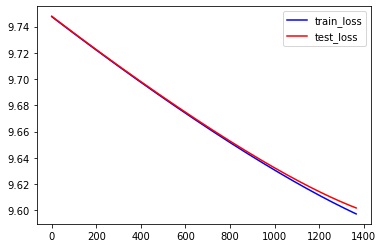

In [19]:
import matplotlib.pyplot as plt
a = [i for i in range(1367)]
plt.plot(a, train_loss_list,label = 'train_loss', c = 'b')
plt.plot(a, test_loss_list,label = 'test_loss', c = 'r')
plt.legend()
plt.show()

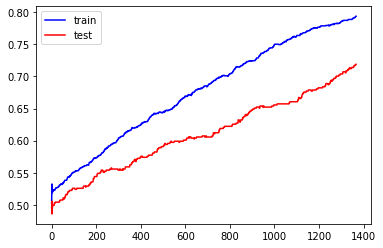

In [20]:
plt.plot(a, train_acc_list,label = 'train', c = 'b')
plt.plot(a, test_acc_list,label = 'test', c = 'r')
plt.legend()
plt.show()